## Steps: 

1. Use Feature Importance (Random Forest / XGBoost feature importance scores) to 
rank variables. 
2. Apply Recursive Feature Elimination (RFE) to select the best predictors. 
3. Use Chi-Square Test to check feature significance. 
4. Select only the most relevant features for modeling

In [1]:
# Load the data
import pandas as pd

df = pd.read_csv('../data/processed_heart_disease.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,0.936181,1,1,0.750380,-0.276443,1,2,0.017494,0,1.068965,3,-0.721976,2,0
1,1.378929,1,4,-0.659431,-0.353500,0,2,-0.899420,1,1.326662,2,1.411625,3,1
2,-1.941680,1,3,-0.095506,0.051047,0,0,1.633010,0,2.099753,3,-0.721976,1,0
3,-1.498933,0,2,-0.095506,-0.835103,0,2,0.978071,0,0.295874,1,-0.721976,1,0
4,0.161372,1,2,-0.659431,-0.218651,0,0,1.240047,0,-0.219520,1,-0.721976,1,0


## 1. Use Feature Importance (Random Forest / XGBoost feature importance scores) to rank variables.

### 1.1 Using Random Forest

In [2]:
from sklearn.ensemble import RandomForestClassifier

X = df.drop('num', axis=1)
y = df['num']

rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

importances_rf = pd.Series(rf.feature_importances_, index=X.columns)
importances_rf.sort_values(ascending=False, inplace=True)

print("Feature importances (Random Forest):")
print(importances_rf)

Feature importances (Random Forest):
thal        0.148232
cp          0.126381
thalach     0.115944
oldpeak     0.110392
age         0.100756
ca          0.092167
chol        0.076724
trestbps    0.071028
exang       0.053546
slope       0.043830
sex         0.033275
restecg     0.020082
fbs         0.007642
dtype: float64


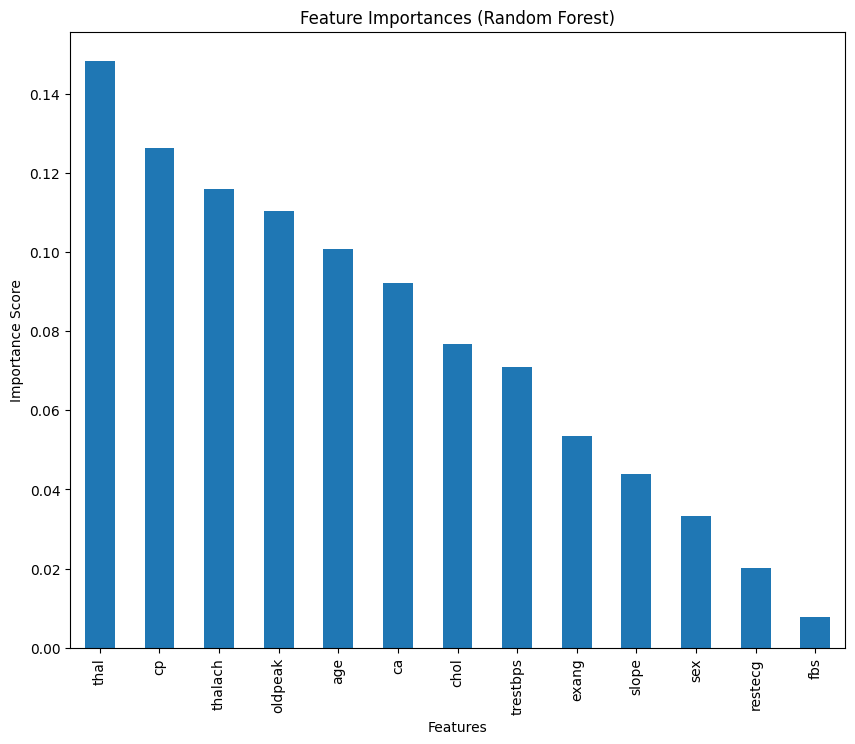

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
importances_rf.plot(kind='bar')
plt.title('Feature Importances (Random Forest)')
plt.ylabel('Importance Score')
plt.xlabel('Features')
plt.show()

### 1.2 Using XGBoost 

In [4]:
import xgboost as xgb
from xgboost import XGBClassifier

xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X, y)

importances_xgb = pd.Series(xgb_model.feature_importances_, index=X.columns)
importances_xgb.sort_values(ascending=False, inplace=True)

print("Feature importances (XGBoost):")
print(importances_xgb)

Feature importances (XGBoost):
thal        0.321294
cp          0.145037
ca          0.110284
exang       0.071435
oldpeak     0.057474
sex         0.057438
slope       0.048735
age         0.047939
chol        0.034746
thalach     0.032035
fbs         0.031089
trestbps    0.024222
restecg     0.018273
dtype: float32


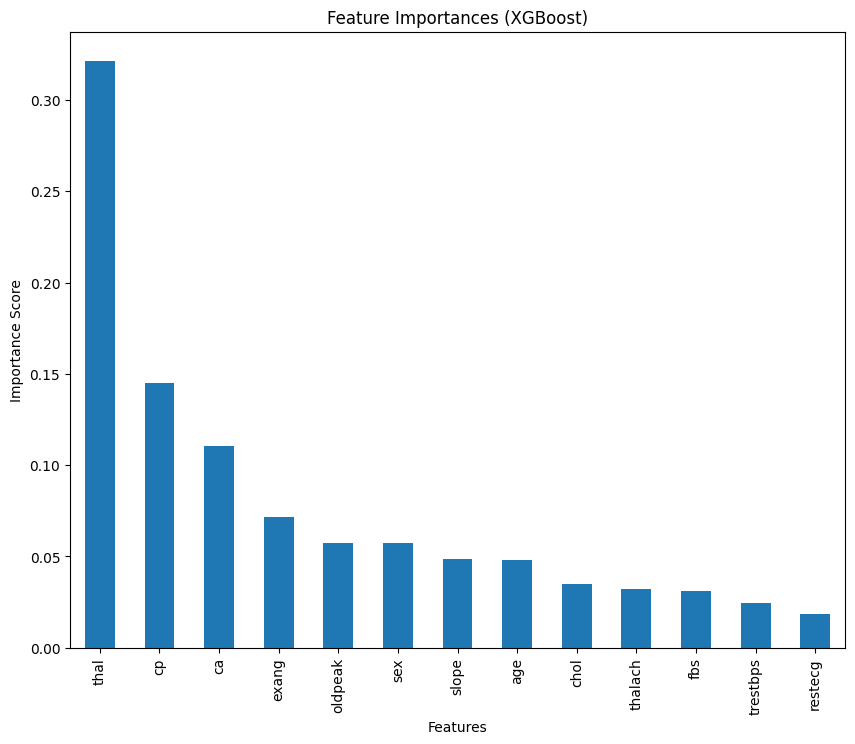

In [5]:
plt.figure(figsize=(10, 8))
importances_xgb.plot(kind='bar')
plt.title('Feature Importances (XGBoost)')
plt.ylabel('Importance Score')
plt.xlabel('Features')
plt.show()

## 2. Apply Recursive Feature Elimination (RFE) to select the best predictors. 

In [6]:
from sklearn.feature_selection import RFE

rfe = RFE(estimator=rf, n_features_to_select=10)
rfe.fit(X, y)

selected_features = X.columns[rfe.support_]
print("Selected features by RFE:")
print(selected_features)

Selected features by RFE:
Index(['age', 'cp', 'trestbps', 'chol', 'thalach', 'exang', 'oldpeak', 'slope',
       'ca', 'thal'],
      dtype='object')


In [7]:
xgbe = RFE(estimator=xgb_model, n_features_to_select=10)
xgbe.fit(X, y)

selected_features_xgb = X.columns[xgbe.support_]
print("Selected features by RFE (XGBoost):")
print(selected_features_xgb)

Selected features by RFE (XGBoost):
Index(['age', 'sex', 'cp', 'chol', 'thalach', 'exang', 'oldpeak', 'slope',
       'ca', 'thal'],
      dtype='object')


In [8]:
selected_features_all = set(selected_features).union(set(selected_features_xgb))

print("Combined selected features from both models:")
selected_features_all = list(selected_features_all)
selected_features_all

Combined selected features from both models:


['oldpeak',
 'ca',
 'chol',
 'exang',
 'cp',
 'sex',
 'thalach',
 'trestbps',
 'age',
 'thal',
 'slope']

## 3. Use Chi-Square Test to check feature significance. 

In [9]:
from sklearn.feature_selection import chi2
import numpy as np

X_chi2 = X.copy()
# Shift all columns to be non-negative
X_chi2 = X_chi2 - X_chi2.min()

chi2_scores, p_values = chi2(X_chi2, y)
chi2_results = pd.DataFrame({
    'Feature': X.columns,
    'Chi2 Score': chi2_scores,
    'p-value': p_values
}).sort_values('Chi2 Score', ascending=False)

print("Chi-Square Test Results:")
print(chi2_results)

Chi-Square Test Results:
     Feature  Chi2 Score       p-value
12      thal   90.775658  1.609209e-21
11        ca   58.324749  2.222307e-14
9    oldpeak   45.624025  1.432735e-11
8      exang   31.296869  2.214364e-08
2         cp   18.393511  1.796688e-05
10     slope   16.802939  4.146903e-05
7    thalach   14.699295  1.260936e-04
1        sex    8.300846  3.962661e-03
6    restecg    6.325256  1.190303e-02
0        age    3.770436  5.216602e-02
3   trestbps    0.869189  3.511798e-01
4       chol    0.740365  3.895441e-01
5        fbs    0.001051  9.741397e-01


In [10]:
significant_features = chi2_results[chi2_results['p-value'] < 0.05]['Feature'].tolist()
print("Significant features based on Chi-Square Test (p < 0.05):")
print(significant_features)

Significant features based on Chi-Square Test (p < 0.05):
['thal', 'ca', 'oldpeak', 'exang', 'cp', 'slope', 'thalach', 'sex', 'restecg']


## 4. Select only the most relevant features for modeling

In [11]:
# Combine the selected features from RFE and significant features from Chi-Square Test
combined_features = set(selected_features_all).intersection(set(significant_features))
print("Combined features from RFE and Chi-Square Test:")
print(combined_features)

Combined features from RFE and Chi-Square Test:
{'oldpeak', 'sex', 'ca', 'thalach', 'exang', 'thal', 'cp', 'slope'}


In [12]:
df_selected = df[list(combined_features) + ['num']]
print("Dataframe with selected features for modeling:")
df_selected.head()

Dataframe with selected features for modeling:


,oldpeak,sex,ca,thalach,exang,thal,cp,slope,num
0,1.068965,1,-0.721976,0.017494,0,2,1,3,0
1,1.326662,1,1.411625,-0.899420,1,3,4,2,1
2,2.099753,1,-0.721976,1.633010,0,1,3,3,0
3,0.295874,0,-0.721976,0.978071,0,1,2,1,0
4,-0.219520,1,-0.721976,1.240047,0,1,2,1,0


## Save the selected features

In [13]:
df_selected.to_csv('../data/selected_features_heart_disease.csv', index=False)